# **1. Install StarDist and dependencies**
---


## **1.1. Install key dependencies**
---
<font size = 4> 

In [1]:
#Not necessary to run anymore

!pip install stardist
!pip install pandas
!pip install scikit-learn
!pip install astropy
!pip install ipywidgets

## **1.3. Load key dependencies**
---
<font size = 4> 

In [2]:
#@markdown ##Load key dependencies
from __future__ import print_function, unicode_literals, absolute_import, division
Notebook_version = '1.13'
Network = 'StarDist 2D'

from builtins import any as b_any

def get_requirements_path():
    # Store requirements file in 'contents' directory 
    current_dir = os.getcwd()
    dir_count = current_dir.count('/') - 1
    path = '../' * (dir_count) + 'requirements.txt'
    return path

def filter_files(file_list, filter_list):
    filtered_list = []
    for fname in file_list:
        if b_any(fname.split('==')[0] in s for s in filter_list):
            filtered_list.append(fname)
    return filtered_list

def build_requirements_file(before, after):
    path = get_requirements_path()

    # Exporting requirements.txt for local run
    !pip freeze > $path

    # Get minimum requirements file
    df = pd.read_csv(path, delimiter = "\n")
    mod_list = [m.split('.')[0] for m in after if not m in before]
    req_list_temp = df.values.tolist()
    req_list = [x[0] for x in req_list_temp]

    # Replace with package name and handle cases where import name is different to module name
    mod_name_list = [['sklearn', 'scikit-learn'], ['skimage', 'scikit-image']]
    mod_replace_list = [[x[1] for x in mod_name_list] if s in [x[0] for x in mod_name_list] else s for s in mod_list] 
    filtered_list = filter_files(req_list, mod_replace_list)

    file=open(path,'w')
    for item in filtered_list:
        file.writelines(item + '\n')

    file.close()

import sys
before = [str(m) for m in sys.modules]


#%load_ext memory_profiler


#%tensorflow_version 1.x

import tensorflow
print(tensorflow.__version__)
print("Tensorflow enabled.")


import imagecodecs

# ------- Variable specific to Stardist -------
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available, relabel_image_stardist, random_label_cmap,  relabel_image_stardist, _draw_polygons, export_imagej_rois
from stardist.models import Config2D, StarDist2D, StarDistData2D # import objects
from stardist.matching import matching_dataset

from csbdeep.utils import Path, normalize, download_and_extract_zip_file, plot_history # for loss plot
from csbdeep.io import save_tiff_imagej_compatible
import numpy as np
np.random.seed(42)
lbl_cmap = random_label_cmap()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from PIL import Image
import zarr
from zipfile import ZIP_DEFLATED
from csbdeep.data import Normalizer, normalize_mi_ma
import imagecodecs


class MyNormalizer(Normalizer):
    def __init__(self, mi, ma):
            self.mi, self.ma = mi, ma
    def before(self, x, axes):
        return normalize_mi_ma(x, self.mi, self.ma, dtype=np.float32)
    def after(*args, **kwargs):
        assert False
    @property
    def do_after(self):
        return False



# ------- Common variable to all ZeroCostDL4Mic notebooks -------
import numpy as np
from matplotlib import pyplot as plt
import urllib
import os, random
import shutil 
import zipfile
from tifffile import imread, imsave
import time
import sys
import wget
from pathlib import Path
import pandas as pd
import csv
from glob import glob
from scipy import signal
from scipy import ndimage
from skimage import io
from sklearn.linear_model import LinearRegression
from skimage.util import img_as_uint
import matplotlib as mpl
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio as psnr
from astropy.visualization import simple_norm
from skimage import img_as_float32, img_as_ubyte, img_as_float
from skimage.util import img_as_ubyte
from tqdm import tqdm 
import cv2
from fpdf import FPDF, HTMLMixin
from datetime import datetime
from pip._internal.operations.freeze import freeze
import subprocess

# For sliders and dropdown menu and progress bar
from ipywidgets import interact
import ipywidgets as widgets

# Colors for the warning messages
class bcolors:
  WARNING = '\033[31m'
W  = '\033[0m'  # white (normal)
R  = '\033[31m' # red

#Disable some of the tensorflow warnings
import warnings
warnings.filterwarnings("ignore")

print('------------------------------------------')
print("Libraries installed")


# Check if this is the latest version of the notebook
All_notebook_versions = pd.read_csv("https://raw.githubusercontent.com/HenriquesLab/ZeroCostDL4Mic/master/Colab_notebooks/Latest_Notebook_versions.csv", dtype=str)
print('Notebook version: '+Notebook_version)
Latest_Notebook_version = All_notebook_versions[All_notebook_versions["Notebook"] == Network]['Version'].iloc[0]
print('Latest notebook version: '+Latest_Notebook_version)
if Notebook_version == Latest_Notebook_version:
  print("This notebook is up-to-date.")
else:
  print(bcolors.WARNING +"A new version of this notebook has been released. We recommend that you download it at https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki")



# PDF export

def pdf_export(trained=False, augmentation = False, pretrained_model = False):
  class MyFPDF(FPDF, HTMLMixin):
    pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B') 

  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Training report for '+Network+' model ('+model_name+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L') 
    
  # add another cell 
  if trained:
    training_time = "Training time: "+str(hour)+ "hour(s) "+str(mins)+"min(s) "+str(round(sec))+"sec(s)"
    pdf.cell(190, 5, txt = training_time, ln = 1, align='L')
  pdf.ln(1)

  Header_2 = 'Information for your materials and method:'
  pdf.cell(190, 5, txt=Header_2, ln=1, align='L')

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '
  #print(all_packages)

  #Main Packages
  main_packages = ''
  version_numbers = []
  for name in ['tensorflow','numpy','Keras','csbdeep']:
    find_name=all_packages.find(name)
    main_packages = main_packages+all_packages[find_name:all_packages.find(',',find_name)]+', '
    #Version numbers only here:
    version_numbers.append(all_packages[find_name+len(name)+2:all_packages.find(',',find_name)])

  cuda_version = subprocess.run('nvcc --version',stdout=subprocess.PIPE, shell=True)
  cuda_version = cuda_version.stdout.decode('utf-8')
  cuda_version = cuda_version[cuda_version.find(', V')+3:-1]
  gpu_name = subprocess.run('nvidia-smi',stdout=subprocess.PIPE, shell=True)
  gpu_name = gpu_name.stdout.decode('utf-8')
  gpu_name = gpu_name[gpu_name.find('Tesla'):gpu_name.find('Tesla')+10]
  #print(cuda_version[cuda_version.find(', V')+3:-1])
  #print(gpu_name)

  shape = io.imread(Training_source+'/'+os.listdir(Training_source)[1]).shape
  dataset_size = len(os.listdir(Training_source))

  text = 'The '+Network+' model was trained from scratch for '+str(number_of_epochs)+' epochs on '+str(dataset_size)+' paired image patches (image dimensions: '+str(shape)+', patch size: ('+str(patch_size)+','+str(patch_size)+')) with a batch size of '+str(batch_size)+' and a '+conf.train_dist_loss+' loss function, using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), csbdeep (v '+version_numbers[3]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'

  #text = 'The '+Network+' model ('+model_name+') was trained using '+str(dataset_size)+' paired images (image dimensions: '+str(shape)+') using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), csbdeep (v '+version_numbers[3]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The GPU used was a '+gpu_name+'.'

  if pretrained_model:
    text = 'The '+Network+' model was trained for '+str(number_of_epochs)+' epochs on '+str(dataset_size)+' paired image patches (image dimensions: '+str(shape)+', patch size: ('+str(patch_size)+','+str(patch_size)+')) with a batch size of '+str(batch_size)+' and a '+conf.train_dist_loss+' loss function, using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). The model was retrained from a pretrained model. Key python packages used include tensorflow (v '+version_numbers[0]+'), Keras (v '+version_numbers[2]+'), csbdeep (v '+version_numbers[3]+'), numpy (v '+version_numbers[1]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+'GPU.'

  pdf.set_font('')
  pdf.set_font_size(10.)
  pdf.multi_cell(190, 5, txt = text, align='L')
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.ln(1)
  pdf.cell(28, 5, txt='Augmentation: ', ln=0)
  pdf.set_font('')
  if augmentation:
    aug_text = 'The dataset was augmented by a factor of '+str(Multiply_dataset_by)
    
  else:
    aug_text = 'No augmentation was used for training.'
  pdf.multi_cell(190, 5, txt=aug_text, align='L')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Parameters', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  if Use_Default_Advanced_Parameters:
    pdf.cell(200, 5, txt='Default Advanced Parameters were enabled')
  pdf.cell(200, 5, txt='The following parameters were used for training:')
  pdf.ln(1)
  html = """ 
  <table width=40% style="margin-left:0px;">
    <tr>
      <th width = 50% align="left">Parameter</th>
      <th width = 50% align="left">Value</th>
    </tr>
    <tr>
      <td width = 50%>number_of_epochs</td>
      <td width = 50%>{0}</td>
    </tr>
    <tr>
      <td width = 50%>patch_size</td>
      <td width = 50%>{1}</td>
    </tr>
    <tr>
      <td width = 50%>batch_size</td>
      <td width = 50%>{2}</td>
    </tr>
    <tr>
      <td width = 50%>number_of_steps</td>
      <td width = 50%>{3}</td>
    </tr>
    <tr>
      <td width = 50%>percentage_validation</td>
      <td width = 50%>{4}</td>
    </tr>
      <tr>
      <td width = 50%>n_rays</td>
      <td width = 50%>{5}</td>
    </tr>
      <tr>
      <td width = 50%>grid_parameter</td>
      <td width = 50%>{6}</td>
    </tr>
    <tr>
      <td width = 50%>initial_learning_rate</td>
      <td width = 50%>{7}</td>
    </tr>
  </table>
  """.format(number_of_epochs,str(patch_size)+'x'+str(patch_size),batch_size,number_of_steps,percentage_validation,n_rays,grid_parameter,initial_learning_rate)
  pdf.write_html(html)

  #pdf.multi_cell(190, 5, txt = text_2, align='L')
  pdf.set_font("Arial", size = 11, style='B')
  pdf.ln(1)
  pdf.cell(190, 5, txt = 'Training Dataset', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(30, 5, txt= 'Training_source:', align = 'L', ln=0)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = Training_source, align = 'L')
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(28, 5, txt= 'Training_target:', align = 'L', ln=0)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = Training_target, align = 'L')
  #pdf.cell(190, 5, txt=aug_text, align='L', ln=1)
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(21, 5, txt= 'Model Path:', align = 'L', ln=0)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = model_path+'/'+model_name, align = 'L')
  pdf.ln(1)
  pdf.cell(60, 5, txt = 'Example Training pair', ln=1)
  pdf.ln(1)
  exp_size = io.imread('/content/TrainingDataExample_StarDist2D.png').shape
  pdf.image('/content/TrainingDataExample_StarDist2D.png', x = 11, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
  pdf.ln(1)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "Democratising deep learning for microscopy with ZeroCostDL4Mic." Nature Communications (2021).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  ref_2 = '- StarDist 2D: Schmidt, Uwe, et al. "Cell detection with star-convex polygons." International Conference on Medical Image Computing and Computer-Assisted Intervention. Springer, Cham, 2018.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')
  if augmentation:
    ref_4 = '- Augmentor: Bloice, Marcus D., Christof Stocker, and Andreas Holzinger. "Augmentor: an image augmentation library for machine learning." arXiv preprint arXiv:1708.04680 (2017).'
    pdf.multi_cell(190, 5, txt = ref_4, align='L')
  pdf.ln(3)
  reminder = 'Important:\nRemember to perform the quality control step on all newly trained models\nPlease consider depositing your training dataset on Zenodo'
  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')

  pdf.output(model_path+'/'+model_name+'/'+model_name+"_training_report.pdf")


def qc_pdf_export():
  class MyFPDF(FPDF, HTMLMixin):
      pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B') 

  Network = 'Stardist 2D'

  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Quality Control report for '+Network+' model ('+QC_model_name+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L') 

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '

  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(2)
  pdf.cell(190, 5, txt = 'Development of Training Losses', ln=1, align='L')
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'/Quality Control/lossCurvePlots.png').shape
  if os.path.exists(full_QC_model_path+'/Quality Control/lossCurvePlots.png'):
    pdf.image(full_QC_model_path+'/Quality Control/lossCurvePlots.png', x = 11, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
  else:
    pdf.set_font('')
    pdf.set_font('Arial', size=10)
    pdf.multi_cell(190, 5, txt='If you would like to see the evolution of the loss function during training please play the first cell of the QC section in the notebook.')
  pdf.ln(2)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.ln(3)
  pdf.cell(80, 5, txt = 'Example Quality Control Visualisation', ln=1)
  pdf.ln(1)
  exp_size = io.imread(full_QC_model_path+'/Quality Control/QC_example_data.png').shape
  pdf.image(full_QC_model_path+'/Quality Control/QC_example_data.png', x = 16, y = None, w = round(exp_size[1]/10), h = round(exp_size[0]/10))
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Quality Control Metrics', align='L', ln=1)
  pdf.set_font('')
  pdf.set_font_size(10.)

  pdf.ln(1)
  html = """
  <body>
  <font size="7" face="Courier New" >
  <table width=100% style="margin-left:0px;">"""
  with open(full_QC_model_path+'/Quality Control/Quality_Control for '+QC_model_name+'.csv', 'r') as csvfile:
    metrics = csv.reader(csvfile)
    header = next(metrics)
    #image = header[0]
    #PvGT_IoU = header[1]
    fp = header[2]
    tp = header[3]
    fn = header[4]
    precision = header[5]
    recall = header[6]
    acc = header[7]
    f1 = header[8]
    n_true = header[9]
    n_pred = header[10]
    mean_true = header[11]
    mean_matched = header[12]
    panoptic = header[13]
    header = """
    <tr>
    <th width = 5% align="center">{0}</th>
    <th width = 12% align="center">{1}</th>
    <th width = 6% align="center">{2}</th>
    <th width = 6% align="center">{3}</th>
    <th width = 6% align="center">{4}</th>
    <th width = 5% align="center">{5}</th>
    <th width = 5% align="center">{6}</th>
    <th width = 5% align="center">{7}</th>
    <th width = 5% align="center">{8}</th>
    <th width = 5% align="center">{9}</th>
    <th width = 5% align="center">{10}</th>
    <th width = 10% align="center">{11}</th>
    <th width = 11% align="center">{12}</th>
    <th width = 11% align="center">{13}</th>
    </tr>""".format("image #","Prediction v. GT IoU",'false pos.','true pos.','false neg.',precision,recall,acc,f1,n_true,n_pred,mean_true,mean_matched,panoptic)
    html = html+header
    i=0
    for row in metrics:
      i+=1
      #image = row[0]
      PvGT_IoU = row[1]
      fp = row[2]
      tp = row[3]
      fn = row[4]
      precision = row[5]
      recall = row[6]
      acc = row[7]
      f1 = row[8]
      n_true = row[9]
      n_pred = row[10]
      mean_true = row[11]
      mean_matched = row[12]
      panoptic = row[13]
      cells = """
        <tr>
          <td width = 5% align="center">{0}</td>
          <td width = 12% align="center">{1}</td>
          <td width = 6% align="center">{2}</td>
          <td width = 6% align="center">{3}</td>
          <td width = 6% align="center">{4}</td>
          <td width = 5% align="center">{5}</td>
          <td width = 5% align="center">{6}</td>
          <td width = 5% align="center">{7}</td>
          <td width = 5% align="center">{8}</td>
          <td width = 5% align="center">{9}</td>
          <td width = 5% align="center">{10}</td>
          <td width = 10% align="center">{11}</td>
          <td width = 11% align="center">{12}</td>
          <td width = 11% align="center">{13}</td>
        </tr>""".format(str(i),str(round(float(PvGT_IoU),3)),fp,tp,fn,str(round(float(precision),3)),str(round(float(recall),3)),str(round(float(acc),3)),str(round(float(f1),3)),n_true,n_pred,str(round(float(mean_true),3)),str(round(float(mean_matched),3)),str(round(float(panoptic),3)))
      html = html+cells
    html = html+"""</body></table>"""
    
  pdf.write_html(html)

  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "Democratising deep learning for microscopy with ZeroCostDL4Mic." Nature Communications (2021).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  ref_2 = '- StarDist 2D: Schmidt, Uwe, et al. "Cell detection with star-convex polygons." International Conference on Medical Image Computing and Computer-Assisted Intervention. Springer, Cham, 2018.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')

  pdf.ln(3)
  reminder = 'To find the parameters and other information about how this model was trained, go to the training_report.pdf of this model which should be in the folder of the same name.'

  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')

  pdf.output(full_QC_model_path+'/Quality Control/'+QC_model_name+'_QC_report.pdf')

# Build requirements file for local run
after = [str(m) for m in sys.modules]
build_requirements_file(before, after)

c:\users\equipo\.conda\envs\workenvpy3.7\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\equipo\.conda\envs\workenvpy3.7\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\users\equipo\.conda\envs\workenvpy3.7\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


2.6.0
Tensorflow enabled.
------------------------------------------
Libraries installed
Notebook version: 1.13
Latest notebook version: 1.19
A new version of this notebook has been released. We recommend that you download it at https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki




## **6. Generate prediction(s) from unseen dataset**
---

<font size = 4>In this section the unseen data is processed using the trained model (in section 4). First, your unseen images are uploaded and prepared for prediction. After that your trained model from section 4 is activated and finally saved into your Google Drive.

---

<font size = 4>The current trained model (from section 4.3) can now be used to process images. If an older model needs to be used, please untick the **Use_the_current_trained_model** box and enter the name and path of the model to use. Predicted output images are saved in your **Prediction_folder** folder as restored image stacks (ImageJ-compatible TIFF images).

<font size = 4>**`Data_folder`:** This folder should contains the images that you want to predict using the network that you will train.

<font size = 4>**`Result_folder`:** This folder will contain the predicted output ROI.

<font size = 4>**`Data_type`:** Please indicate if the images you want to predict are single images or stacks


<font size = 4>In stardist the following results can be exported:
- Region of interest (ROI) that can be opened in ImageJ / Fiji. The ROI are saved inside of a .zip file in your choosen result folder. To open the ROI in Fiji, just drag and drop the zip file !**
- The predicted mask images
- A tracking file that can easily be imported into Trackmate to track the nuclei.
- A CSV file that contains the number of nuclei detected per image. 
- A CSV file that contains the coordinate the centre of each detected nuclei (single image only). 



The glomModelIlumCorrected5 network will be used.
Single images are now beeing predicted


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


['E:/AAV para enfermedades renales/LSFM combined images/R2LEC-Path_SRL\\R2LEC-Path_SRL_Z0483_C00.tif', 'E:/AAV para enfermedades renales/LSFM combined images/R2LEC-Path_SRL\\R2LEC-Path_SRL_Z1582_C00.tif']
Total number of images:  2
Number of images to be predicted:  0
Normalizing image channels independently
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.643634, nms_thresh=0.3.


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


FILEnames:  ['E:/AAV para enfermedades renales/LSFM combined images/Results-GlomeruliSeg/R2LEC-Path_SRL/R2LEC-Path_SRL_Z0483_C00.tif', 'E:/AAV para enfermedades renales/LSFM combined images/Results-GlomeruliSeg/R2LEC-Path_SRL/R2LEC-Path_SRL_Z1582_C00.tif']
- image  0  saved as  E:/AAV para enfermedades renales/LSFM combined images/Results-GlomeruliSeg/R2LEC-Path_SRL/R2LEC-Path_SRL_Z0483_C00.tif
FILEnames:  ['E:/AAV para enfermedades renales/LSFM combined images/Results-GlomeruliSeg/R2LEC-Path_SRL/R2LEC-Path_SRL_Z0483_C00.tif', 'E:/AAV para enfermedades renales/LSFM combined images/Results-GlomeruliSeg/R2LEC-Path_SRL/R2LEC-Path_SRL_Z1582_C00.tif']
- image  1  saved as  E:/AAV para enfermedades renales/LSFM combined images/Results-GlomeruliSeg/R2LEC-Path_SRL/R2LEC-Path_SRL_Z1582_C00.tif
One example image is displayed bellow:
Predictions completed


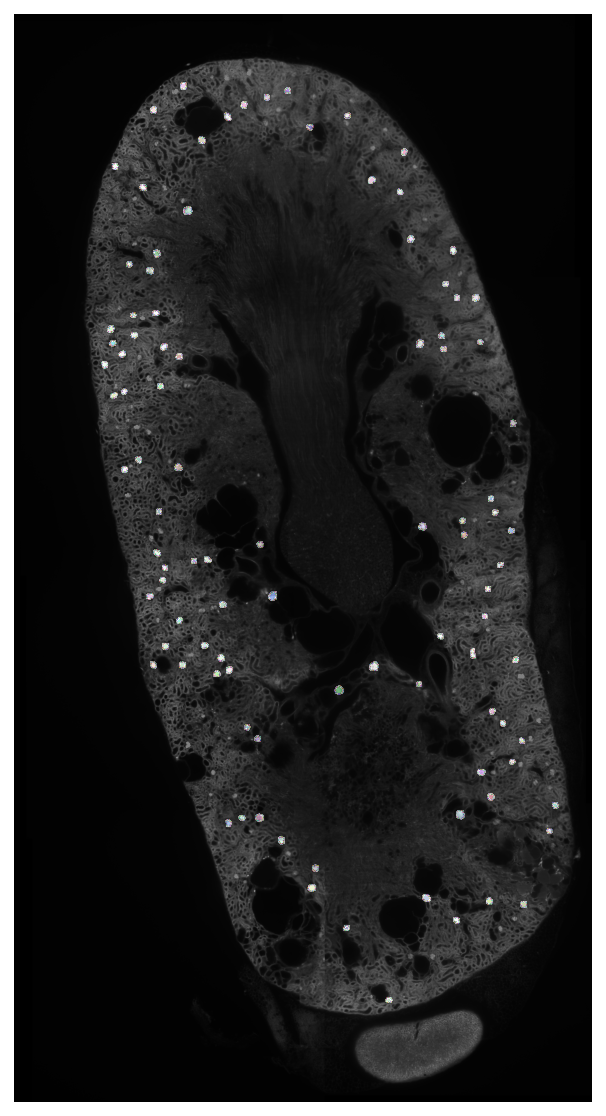

In [18]:
Single_Images = 1
Stacks = 2

# Provide the path to your dataset and to the folder where the prediction will be saved (Result folder), then play the cell to predict output on your unseen images.
#C01 is the lectin channel (the one we are interested in)

#This is the path to a single tile folder. You need to
#Data_folder = '//10.117.178.19/SharedData/AAV para enfermedades renales/MacroSPIM2 (drive)'+\
#'/KidneyR2Right_LectinRed_RLSamples2021/All/RL00--X00--Y00--C00'

Data_folder = 'E:/AAV para enfermedades renales/LSFM combined images/R2LEC-Path_SRL'

#Data_folder = 'E:/MacroSPIM/Kidney1_derecho_4.8x_1x3_R&Lshifted1.6mm/RL01--X00--Y03--C01'
#Data_folder = "D:/AAV para enfermedades renales/Stardist glomeruli/Stardist results on whole image/Small image Brightness Correction/RL01--X00--Y00--C01"

#Specify only the results folder for the whole large image, the different tiles' folders will be created
#Results_folder = '//10.117.178.19/SharedData/AAV para enfermedades renales/MacroSPIM2 (drive)'+\
#'/KidneyR2Right_LectinRed_RLSamples2021/KidneyR2Right_LectinRed_RLSamples2021-GlomeruliSegmentation'

#Results_folder = "D:/AAV para enfermedades renales/Stardist glomeruli/Stardist results on whole image/Result on large image/Kidney1_derecho_4.8x_1x3_R&Lshifted1.6mm"
Results_folder = 'E:/AAV para enfermedades renales/LSFM combined images/'+\
'Results-GlomeruliSeg'

import os

Results_folder= Results_folder + '/' + os.path.basename(Data_folder)

if not os.path.exists(Results_folder):
    os.makedirs(Results_folder)
    


#Are your data single images or stacks? The options are ["Single_Images", "Stacks"]

Data_type = Single_Images 

#What outputs would you like to generate?
Region_of_interests = False 
Mask_images = True 
Tracking_file = False 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#How many images you want to analyze from the folder? (0 means all of them)

numImages =  0#@param {type:"number"}

#Whether you want to invert the image colors or not
invert = False
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# model name and path
#Do you want to use the current trained model?
Use_the_current_trained_model = False 

#If not, please provide the path to the model folder:

Prediction_model_folder = 'E:/AAV para enfermedades renales/Stardist glomeruli/'+\
'Stardist results on whole image/glomModelIlumCorrected5'



#Here we find the loaded model name and parent path
Prediction_model_name = os.path.basename(Prediction_model_folder)
Prediction_model_path = os.path.dirname(Prediction_model_folder)




if (Use_the_current_trained_model): 
  print("Using current trained network")
  Prediction_model_name = model_name
  Prediction_model_path = model_path

full_Prediction_model_path = Prediction_model_path+'/'+Prediction_model_name+'/'
if os.path.exists(full_Prediction_model_path):
  print("The "+Prediction_model_name+" network will be used.")
else:
  print(bcolors.WARNING+'!! WARNING: The chosen model does not exist !!'+W)
  print('Please make sure you provide a valid model path and model name before proceeding further.')

#single images

if Data_type == 1 :

  Data_folder = Data_folder+"/*.tif"

  print("Single images are now beeing predicted")
  np.random.seed(16)
  lbl_cmap = random_label_cmap()
  X = sorted(glob(Data_folder))
  print(X)
  #~~~~~~~~~~~~~~~~~~
  #X = list(map(imread,X))
  #~~~~~~~~~~~~~~~~~~

  print('Total number of images: ',len(X))

  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  #Here we find the images already created in a previous run
  prevCreatedNames = [os.path.basename(f) for f in sorted(glob(Results_folder+'/*.tif'))]

  prevCreatedFILEnames = []
  for m in prevCreatedNames:
    m = Results_folder+'/'+m
    prevCreatedFILEnames.append(m)
  
  #Get rid of the first image names (already predicted)
  X = X[len(prevCreatedFILEnames):]

  print('Number of images to be predicted: ',numImages)
  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  n_channel = 1 

  #~~~~~~~~~~~~~~~~~~~~
  n_channel = 1 if imread(X[0]).ndim == 2 else imread(X[0]).shape[-1]
  #~~~~~~~~~~~~~~~~~~~~

  # axis_norm = (0,1,2) # normalize channels jointly
  if n_channel == 1:
    axis_norm = (0,1)   # normalize channels independently
    print("Normalizing image channels independently")

  if n_channel > 1:
    axis_norm = (0,1,2) # normalize channels jointly
    print("Normalizing image channels jointly")  
    sys.stdout.flush()  
  
  model = StarDist2D(None, name = Prediction_model_name, basedir = Prediction_model_path)
 

  names = [os.path.basename(f) for f in sorted(glob(Data_folder))[len(prevCreatedFILEnames):]]  
  Nuclei_number = []



  # modify the names to suitable form: path_images/image_numberX.tif
  FILEnames = []
  for m in names:
    m = Results_folder+'/'+m
    FILEnames.append(m)

  # Create a list of name with no extension
 
  name_no_extension=[]
  for n in names:
    name_no_extension.append(os.path.splitext(n)[0])


  # Save all ROIs and masks into results folder
  
  for i in range(len(X)):

      #~~~~~~~~~~~~~~~~~~~~~~~~~~~~
      origIm = imread(X[i])

      if invert == True:
        origIm = np.abs(origIm-np.max(origIm))
      #~~~~~~~~~~~~~~~~~~~~~~~~~~~~

      img = normalize(origIm, 1,99.8, axis = axis_norm)
      labels, polygons = model.predict_instances(img)
      
      #print(i)

      os.chdir(Results_folder)

      if Mask_images:
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        
        #Reduce the bit depth of the result
        labels = labels.astype(np.uint8)
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        print('FILEnames: ',FILEnames)
        
        imsave(FILEnames[i], labels, polygons)
        
        #~~~~
        print('- image ',i+len(prevCreatedNames),' saved as ',FILEnames[i])
        #~~~~

      if Region_of_interests:
        export_imagej_rois(name_no_extension[i], polygons['coord'])

      if Tracking_file:
        Tracking_image = np.zeros((img.shape[1], img.shape[0]))
        for point in polygons['points']:
          cv2.circle(Tracking_image,tuple(point),0,(1), -1)
        
        Tracking_image_32 = img_as_float32(Tracking_image, force_copy=False)
        Tracking_image_8 = img_as_ubyte(Tracking_image, force_copy=True)      
        Tracking_image_8_rot = np.rot90(Tracking_image_8, axes=(0, 1))
        Tracking_image_8_rot_flip = np.flipud(Tracking_image_8_rot)
        imsave(Results_folder+"/"+str(name_no_extension[i])+"_tracking_file.tif", Tracking_image_8_rot_flip, compress=ZIP_DEFLATED)
      
      Nuclei_centre_coordinate = polygons['points']
      my_df2 = pd.DataFrame(Nuclei_centre_coordinate)
      my_df2.columns =['Y', 'X']
      
      #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
      #Don't store the nuclei centers
      #my_df2.to_csv(Results_folder+'/'+name_no_extension[i]+'_Nuclei_centre.csv', index=False, header=True)

      #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

      Nuclei_array = polygons['coord']
      Nuclei_array2 = [names[i], Nuclei_array.shape[0]]
      Nuclei_number.append(Nuclei_array2)

      #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
      #If a limit of images was specified (numImages != 0) and this limit has been reached (imCount == numImages)
      #stop the loop 
      if i == numImages-1:
        break
      #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

  my_df = pd.DataFrame(Nuclei_number)
  my_df2.columns =['Frame number', 'Number of objects']
  my_df.to_csv(Results_folder+'/Nuclei_count.csv', index=False, header=False)
  
# One example is displayed

  print("One example image is displayed bellow:")
  plt.figure(figsize=(10,10))
  plt.imshow(img if img.ndim==2 else img[...,:3], clim=(0,1), cmap='gray')
  plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
  plt.axis('off');
  
  #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  #Do not save the image
  #plt.savefig(name_no_extension[i]+"_overlay.tif")

# Here is the code to analyse stacks

if Data_type == 2 :
  print("Stacks are now beeing predicted")
  np.random.seed(42)
  lbl_cmap = random_label_cmap()

  # normalize channels independently
  axis_norm = (0,1)  
  
  model = StarDist2D(None, name = Prediction_model_name, basedir = Prediction_model_path)
  
  for image in os.listdir(Data_folder):
    print("Performing prediction on: "+image)

    Number_of_nuclei_list = []
    Number_of_frame_list = []

    timelapse = imread(Data_folder+"/"+image)

    short_name = os.path.splitext(image)     
    
    timelapse = normalize(timelapse, 1,99.8, axis=(0,)+tuple(1+np.array(axis_norm)))
    

    if Region_of_interests: 
      polygons = [model.predict_instances(frame)[1]['coord'] for frame in tqdm(timelapse)]    
      export_imagej_rois(Results_folder+"/"+str(short_name[0]), polygons, compression=ZIP_DEFLATED)  
    
    n_timepoint = timelapse.shape[0]
    prediction_stack = np.zeros((n_timepoint, timelapse.shape[1], timelapse.shape[2]))
    Tracking_stack = np.zeros((n_timepoint, timelapse.shape[2], timelapse.shape[1]))

# Analyse each time points one after the other
    if Mask_images or Tracking_file:
      for t in range(n_timepoint):
        img_t = timelapse[t]
        labels, polygons = model.predict_instances(img_t)      
        prediction_stack[t] = labels
        Nuclei_array = polygons['coord']
        Nuclei_array2 = [str(t), Nuclei_array.shape[0]]
        Number_of_nuclei_list.append(Nuclei_array2)
        Number_of_frame_list.append(t)

# Create a tracking file for trackmate

        for point in polygons['points']:
          cv2.circle(Tracking_stack[t],tuple(point),0,(1), -1)

      prediction_stack_32 = img_as_float32(prediction_stack, force_copy=False)
      Tracking_stack_32 = img_as_float32(Tracking_stack, force_copy=False)
      Tracking_stack_8 = img_as_ubyte(Tracking_stack_32, force_copy=True)
      
      Tracking_stack_8_rot = np.rot90(Tracking_stack_8, axes=(1,2))
      Tracking_stack_8_rot_flip = np.fliplr(Tracking_stack_8_rot)

# Export a csv file containing the number of nuclei detected at each frame
      my_df = pd.DataFrame(Number_of_nuclei_list)
      my_df.to_csv(Results_folder+'/'+str(short_name[0])+'_Nuclei_number.csv', index=False, header=False)

      os.chdir(Results_folder)
      if Mask_images:
        imsave(str(short_name[0])+".tif", prediction_stack_32, compress=ZIP_DEFLATED)
      if Tracking_file:
        imsave(str(short_name[0])+"_tracking_file.tif", Tracking_stack_8_rot_flip, compress=ZIP_DEFLATED)

  # Object detected vs frame number
    plt.figure(figsize=(20,5))
    my_df.plot()
    plt.title('Number of objects vs frame number')
    plt.ylabel('Number of detected objects')
    plt.xlabel('Frame number')
    plt.legend()
    plt.savefig(Results_folder+'/'+str(short_name[0])+'_Object_detected_vs_frame_number.png',bbox_inches='tight',pad_inches=0)
    plt.show()         

print("Predictions completed")   